# Part 3: Offer Transition

Once an optimal SCR gradient upper bound (SGUB) is selected, report on offer transitions and changes to total inc-sales and cost.

In [38]:
import os, sys, importlib
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import optimize

sys.path.insert(0, '/home/jovyan/a01_repos')
import wx_tools.Wx_Utils as utl
# importlib.reload(sys.modules['Wx_Utils'])

sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')
import joe_utils.UDF_Visualisation as viz

# Project specific functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

sns.set_palette(sns.color_palette("muted", 10))
# sns.palplot(sns.color_palette("pastel", 10))

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [31]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Prep

In [32]:
# Load data
scored_top2 = pd.read_parquet('data/scored_top2.parquet')
scored_top2.shape
scored_top2.tail(2)

(11208, 38)

crn  offerId hurdle_cat reward_cat campaign_type  \
11206  3300000000002655674  -177579          L          H            ss   
11207  3300000000002655674  -177578          L          M            ss   

      campaign_level campaign_category campaign_duration  camp_dur_wks cvm  \
11206          store                na                11          11.0  1T   
11207          store                na                11          11.0  1T   

       ...  inc_sales_diff_perc  target_cost_diff  target_cost_diff_perc  \
11206  ...             0.000000           0.00000               0.000000   
11207  ...            -4.122585          -0.19944             -36.438198   

       scr_gradient        scr  scr_diff  scr_diff_perc  score_diff  \
11206           NaN   6.801918  0.000000       0.000000     0.00000   
11207      0.769563  10.260097  3.458179      50.841236    -0.01519   

       score_diff_perc  rank  
11206         0.000000     1  
11207        -1.521878     2  

[2 rows x 38 columns]

In [33]:
cols = [
    'crn', 'offerId',
    'rank', 'score', 'inc_sales', 'target_cost',
    'scr', 'scr_gradient',
    'campaign_type','campaign_level','campaign_category',
    'cvm','multiplier',
]
scored_top2[cols].head()

crn  offerId  rank     score  inc_sales  target_cost  \
0  1000000000000000123       na     1  1.000000   0.000000     0.000000   
1  1000000000000000123  -151044     2  0.950000  -0.948526     0.089242   
2  1000000000000005953  -177547     1  0.999020   2.110014     1.352413   
3  1000000000000005953  -177546     2  0.981373   2.059573     1.155072   
4  1000000000000007310  -151129     1  0.957143   0.487251     0.000000   

         scr  scr_gradient campaign_type campaign_level campaign_category  \
0        NaN           NaN            na           None                na   
1 -10.628664    -10.628664            ss          store                na   
2   1.560185           NaN            tu          store                na   
3   1.783068      0.255606            tu          store                na   
4        inf           NaN            mp          store                na   

      cvm  multiplier  
0  Lapsed         NaN  
1  Lapsed         0.0  
2    MVML         0.0  
3    MVML         0.0  
4     LVL         5.0

In [34]:
scored_top2['campaign_category'].value_counts()

na         9305
beer        842
wine        646
spirits     415
Name: campaign_category, dtype: int64

In [35]:
# Best offer
scored_best = pd.read_parquet('data/decision_model_999.parquet')
scored_best['rank'] = 1
scored_best.shape
scored_best.tail(2)

(5044, 29)

crn  offerId hurdle_cat reward_cat campaign_type  \
263213  3300000000002637923  -151044          M          H            ss   
178199  3300000000002655674  -177579          L          H            ss   

       campaign_level campaign_category campaign_duration  camp_dur_wks   cvm  \
263213          store                na                11          11.0  MVML   
178199          store                na                11          11.0    1T   

        ...    spd|rdm  spd|not_rdm   base_spd   p_unsub  target_spd  \
263213  ...  42.982464     7.753791   7.883183  0.000473    9.199431   
178199  ...  60.786030    11.112351  10.684954  0.000451   14.407896   

        target_cost  inc_sales     score  select_prob_weight  rank  
263213     0.246215   1.316249  0.995902            1.111111     1  
178199     0.547337   3.722942  0.998101            1.111111     1  

[2 rows x 29 columns]

In [36]:
# Missing crns in best offer were assigned to random group
crn_missing = list(set(scored_top2['crn']) - set(scored_best['crn']))
len(crn_missing)

# View sample of misisng crns
cond = scored_top2['crn'].isin(crn_missing)
# scored_top2[cond].head()

# Analysis without missing crn
scored_top2 = scored_top2[~cond]
scored_top2.shape
scored_top2['crn'].nunique()

560

(10088, 38)

5044

## Scripting

In [40]:
base_metrics = scored_best[['inc_sales', 'target_cost']].sum()
base_metrics['net_revenue'] = base_metrics[0] - base_metrics[1]
base_metrics['scr'] = base_metrics['inc_sales'] / base_metrics['target_cost']

In [41]:
# From Part 2: optimal SGUB
# SCR_GRADIENT_UB = 0.53

# COBYLA (Constrained optimisation by linear approximation)
x0 = 0.5
ub_c1= np.inf #100
ub_c2= np.inf #2.0
   
x_opt = optimize.fmin_cobyla(udf.obj_func, x0, udf.constr_ineq,
                             args=(scored_top2, base_metrics),
                             consargs=(scored_top2, base_metrics, ub_c1, ub_c2))
type(x_opt)
x_opt

numpy.ndarray

array(0.99804688)

In [42]:
# Optimal selection
scored_opt = udf.choose_offer(scored_top2, x_opt)
scored_opt.shape
scored_opt['rank'].value_counts()

(5044, 39)

1    3020
2    2024
Name: rank, dtype: int64

In [43]:
# Summary
catg_col = 'label'
scored_opt = udf.crt_label_col(scored_opt, catg_col)
scored_opt_smry = udf.crt_smry(scored_opt, catg_col)

In [44]:
# Original allocation
scored_best = udf.crt_label_col(scored_best, catg_col)
scored_best_smry = udf.crt_smry(scored_best, catg_col)
scored_best_smry.shape

(30, 7)

## Visualise

In [45]:
InteractiveShell.ast_node_interactivity = "last"

In [46]:
# New 2nd best campaign type volume distribution percentage
label_campaign_type = udf.crt_label_col(scored_opt, catg_col, campaign_level=False, is_rank=False, cvm=False, multiplier=False)
label_campaign_type_smry = udf.crt_smry(label_campaign_type, catg_col)
cond = label_campaign_type_smry['rank'] == '2'
label_campaign_type_smry[cond].groupby('label')['crn_count'].max() / label_campaign_type_smry[cond]['crn_count'].sum() * 100

label
mp    18.280632
na     2.173913
ss    71.492095
tu     8.053360
Name: crn_count, dtype: float64

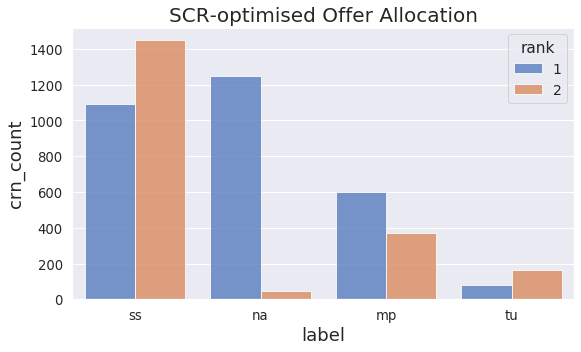

In [47]:
df_plot = label_campaign_type_smry.sort_values(by='crn_count', ascending=False)

fig, ax = plt.subplots()
g = sns.barplot(x=catg_col, y="crn_count", hue="rank", data=df_plot, alpha=0.8, ax=ax)
    
ax.set_title('SCR-optimised Offer Allocation')
plt.show()

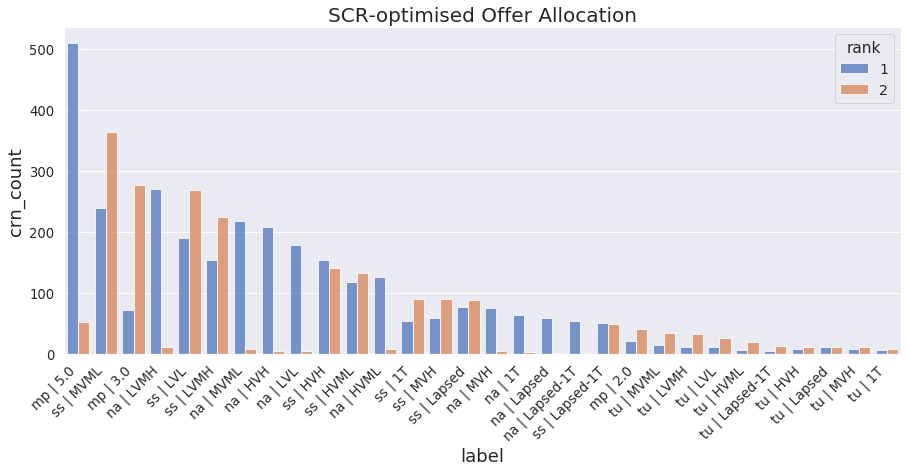

In [49]:
label_no_rank = udf.crt_label_col(scored_opt, catg_col, campaign_level=False, is_rank=False)
label_no_rank_smry = udf.crt_smry(label_no_rank, catg_col)
df_plot = label_no_rank_smry.sort_values(by='crn_count', ascending=False)

fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=catg_col, y="crn_count", hue="rank", data=df_plot, alpha=0.8, ax=ax)
ax.set_title('SCR-optimised Offer Allocation')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

The new offer types with high inflow volume include:

- SS | MVML
- SS | LVL
- SS | LVMH
- SS | HVH
- MP | 3x

We use sankey diagrams to trace the inflow offer types to the above list. We shall also examine the original offers that change to "na" (no offer).

## Sankey Transition - Trace Inflow for new "2" offer type groups

**Observations:**
- 2nd best offers at the campaign type level predominantly come from the best offer of the same campaign type
- majority of changes to SS offer types are from the same SS CVM segment
- the only significant offer type switch is from MP 5x to MP 3x: 18% (155/872) of MP 5x switching
- the majority of offer type switches to no-offer do not change CVM segment

### Trace Campaign Level Flow
- 2nd best offers at the campaign type level predominantly come from the best offer of the same campaign type

In [50]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=False, cvm=False, multiplier=False)
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', rank_incl=['2'],
                    campaign_level=False, cvm=False, multiplier=False)
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Offer Type Transition - Campaign Type')

### SS | MVML
- majority of offers do not change from another offer type; we see small volumes of inflow types TU (5) and MP 5x (7)

In [51]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=True, campaign_type_incl=[])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', rank_incl=['2'],
                    campaign_level=True, campaign_type_incl=['ss'], cvm_multiplier_incl=['MVML'])
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Offer Type Transition - To SS MVML')

### SS | LVL
- majority do not change

In [52]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=True, campaign_type_incl=[])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', rank_incl=['2'],
                    campaign_level=True, campaign_type_incl=['ss'], cvm_multiplier_incl=['LVL'])
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Offer Type Transition - To SS LVL')

### SS | LVMH
- majority do not change

In [53]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=True, campaign_type_incl=[])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', rank_incl=['2'],
                    campaign_level=True, campaign_type_incl=['ss'], cvm_multiplier_incl=['LVMH'])
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Campaign Type Transition - To SS LVMH')

### SS | HVH
- majority do not change

In [54]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=True, campaign_type_incl=[])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', rank_incl=['2'],
                    campaign_level=True, campaign_type_incl=['ss'], cvm_multiplier_incl=['HVH'])
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Campaign Type Transition - To SS HVH')

### MP | 3x
- MP 5x accounts for a large proportion of inflow offer types into MP 3x (155/167 = 93%)
- initially, a large proportion of best offers are MP 5x, so we see a small proportion of MP 5x changing to MP 3x
- the remaining inflow offer types are SS

In [55]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=True, campaign_type_incl=[])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', rank_incl=['2'],
                    campaign_level=True, campaign_type_incl=['mp'], cvm_multiplier_incl=['3.0'])
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Offer Type Transition - To MP 3x')

### Change to No Offer


In [56]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=True, campaign_type_incl=[])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', rank_incl=['2'],
                    campaign_level=False, campaign_type_incl=['na'])
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Offer Type Transition - To No Offer')

### MP Outflow
We plot the change of all best offer MP.
- the majority of MP 5x remains as MP 5x (639/872 = 73%)
- some change to MP 3x (155/872 = 18%)
- the remaining 9% change to SS

In [57]:
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=False, campaign_type_incl=['mp'])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', campaign_level=False, campaign_type_incl=[])
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Offer Type Transition - From MP')

In [58]:
# Collapse CVM segment
src = udf.crt_label_col(scored_best, catg_col, suffix='A', campaign_level=False, campaign_type_incl=['mp'])
tgt = udf.crt_label_col(scored_opt, catg_col, suffix='B', campaign_level=False, campaign_type_incl=[], cvm=False)
sankey_link, sankey_label, sankey = udf.crt_sankey_data(src, tgt, catg_col)
udf.plot_sankey(sankey_link, sankey_label, title='Offer Type Transition - From MP')